In [7]:
import PIL
import os
import torch
import matplotlib.pyplot as plt

# images are in ./data/train
# dog images begin with 'dog'
# cat images begin with 'cat'

cat_image_names=[]
dog_image_names=[]
for file in os.listdir('./data/train'):
    if file.startswith('cat'):
        cat_image_names.append(file)
    else:
        dog_image_names.append(file)

In [8]:
def load_batch_of_images(image_names):
    images=[]
    for image_name in image_names:
        images.append(PIL.Image.open('./data/train/'+image_name))
    return images

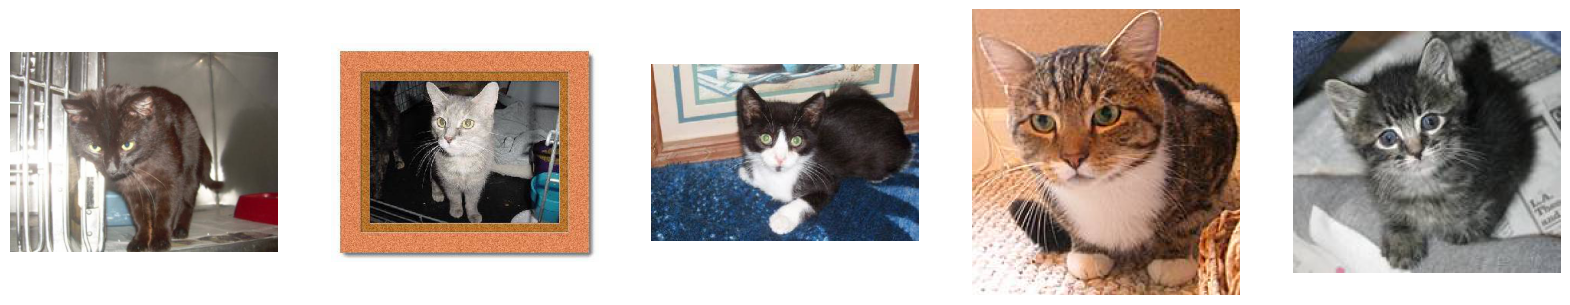

In [11]:
# plot first five cat images
cat_images=load_batch_of_images(cat_image_names[:5])
fig, ax=plt.subplots(1, len(cat_images), figsize=(20, 20))
for i in range(len(cat_images)):
    ax[i].imshow(cat_images[i])
    ax[i].axis('off')
plt.show()

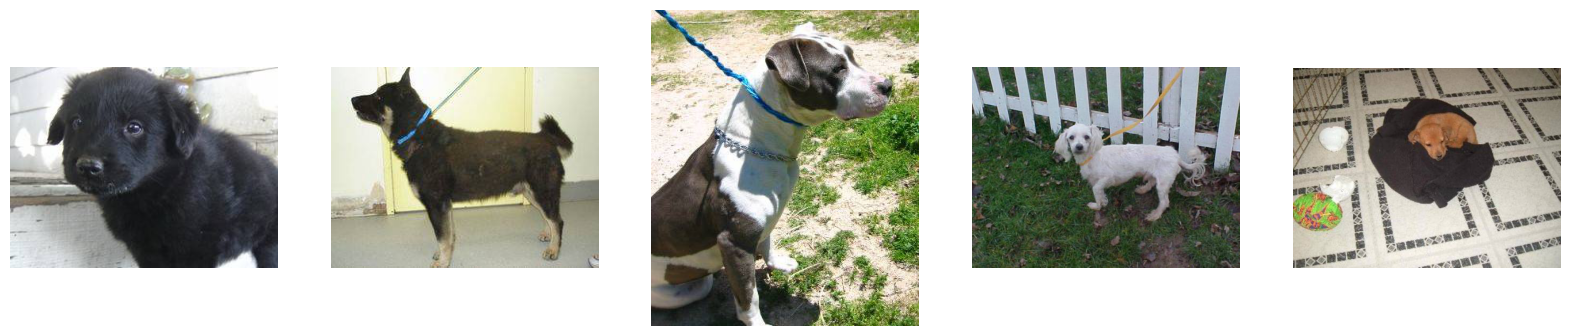

In [12]:
# plot first five dog images
dog_images=load_batch_of_images(dog_image_names[:5])
fig, ax=plt.subplots(1, len(dog_images), figsize=(20, 20))
for i in range(len(dog_images)):
    ax[i].imshow(dog_images[i])
    ax[i].axis('off')
plt.show()